## 7. Image Segmentation with DL

Outline

1. The Dataset
2. Dataset prep
3. U-Net
4. Working with large data that doesn't fit your system memory.
5. Inference
6. Next steps

In Week 1, you have learned image segmentation with traditional computer vision, specifically using thresholding. In this notebook, you will learn how to do image segmentation using deep learning.

We will focus on U-Net, a convolutional neural network (CNN) architecture that has been widely acclaimed for its effectiveness in image segmentation tasks, particularly in the field of biomedical imaging. It was introduced by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in their 2015 paper titled "U-Net: Convolutional Networks for Biomedical Image Segmentation." The architecture is distinct for its "U" shape.

<img src='https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png' width='600'>

This notebook delves into the details of developing a U-Net with Keras.

Before starting with the notebook:

- Read the [U-Net paper](https://arxiv.org/abs/1505.04597)
- Watch the following videos by DigitalSreeni
- [73 - Image Segmentation using U-Net - Part1 (What is U-net?)](https://www.youtube.com/watch?v=azM57JuQpQI)
- [74 - Image Segmentation using U-Net - Part 2 (Defining U-Net in Python using Keras)](https://www.youtube.com/watch?v=68HR_eyzk00)
- [75 - Image Segmentation using U-Net - Part 3 (What are trainable parameters?)](https://www.youtube.com/watch?v=sb0uglcqO2Y)
- [76 - Image Segmentation using U-Net - Part 4 (Model fitting, checkpoints, and callbacks)](https://www.youtube.com/watch?v=0kiroPnV1tM)
- [77 - Image Segmentation using U-Net - Part 5 (Understanding the data)](https://www.youtube.com/watch?v=cUHPL_dk17E)
- [78 - Image Segmentation using U-Net - Part 6 (Running the code and understanding results)](https://www.youtube.com/watch?v=RaswBvMnFxk)

These videos are part of the YouTube playlist [U-net for image segmentation](https://www.youtube.com/watch?v=azM57JuQpQI&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE). Watching all the videos is strongly suggested.

## 1 The Dataset

To demonstrate how to build a U-Net we will use a subset of the [blood cell segmentation dataset](https://github.com/Deponker/Blood-cell-segmentation-dataset).

You can download it from [BSp-Project 2B Team > Files > blood_cell_dataset](https://edubuas.sharepoint.com/:f:/t/course8763/Eii2muNdr8BMulxek8h_WNgBajBGMM4Ge6CYCWE1cO5TIg?e=Vse5L5)

This is a binary segmentation task where the positive class is cell and the negative class is the background. For each image, there is a single mask.

This is the directory structure:

```
blood_cell_dataset/
    train_images/
        train/
            0f735cca-051c-4048-a1fa-cb36f389e12f.png
            0a747cb3-c720-4572-a661-ab5670a5c42e.png
            ...
    train_masks/
        train/
            0f735cca-051c-4048-a1fa-cb36f389e12f.png
            0a747cb3-c720-4572-a661-ab5670a5c42e.png
            ...
    val_images/
        val/
            1d4cdf2e-79a0-41e9-aabe-e437a190dfc4.png
            1d4f06e1-9c9b-487e-84cd-e7e50cc754da.png
            1dd3e6dd-343f-4cc9-b0ed-e4d27fb36f0a.png
            1d9d4dac-66f9-4c87-b714-d723d5b15fa9.png
    val_masks/
        val/
            1d4cdf2e-79a0-41e9-aabe-e437a190dfc4.png
            1d4f06e1-9c9b-487e-84cd-e7e50cc754da.png
            1dd3e6dd-343f-4cc9-b0ed-e4d27fb36f0a.png
            1d9d4dac-66f9-4c87-b714-d723d5b15fa9.png
```

Let's look at an example image and a mask.

(-0.5, 4201.5, 3005.5, -0.5)

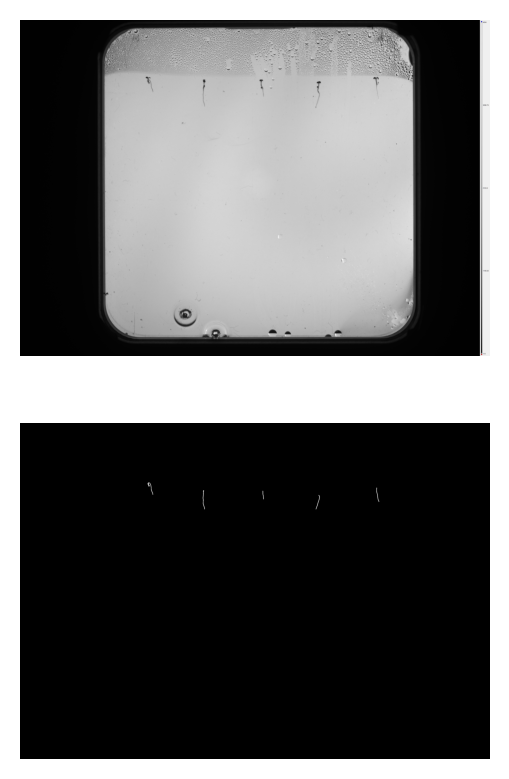

In [2]:
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

image_path = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\roots\train_images\train\001_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_04-Fish Eye Corrected.png'
mask_path = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\roots\train_masks\train\001_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_04-Fish Eye Corrected_root_mask.tif'

image = cv2.imread(image_path)
mask = cv2.imread(mask_path, 0)


fig, ax = plt.subplots(2, dpi=200)
ax[0].imshow(image)
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].axis('off')

In [3]:
# And some dataset info
print(f'Image shape: {image.shape}')
print(f'Mask shape: {mask.shape}')
print(f'Image data type: {image.dtype}')
print(f'Mask data type: {mask.dtype}')
print(f'Image pixel values: {np.min(image)}-{np.max(image)}')
print(f'Mask pixel values: {np.min(mask)}-{np.max(mask)}')

Image shape: (3006, 4202, 3)
Mask shape: (3006, 4202)
Image data type: uint8
Mask data type: uint8
Image pixel values: 0-255
Mask pixel values: 0-1


## 2 Dataset preparation

We need an `X` and a `y` to train a supervised machine learning model. In our case `X` will be the microscope images and `y` will be the masks. But how can we input a (1200, 1600) image into a NN? In Y1C, you have learned to resize it to a square shape. For image classification this might be enough, but for segmentation we want to classify each pixel, therefore we need a different approach.

We can divide the image into smaller patches, develop our network based on these patches, and the stitch the predictions back together to obtain a mask with high resolution.

Let's display patches of size (200, 200):

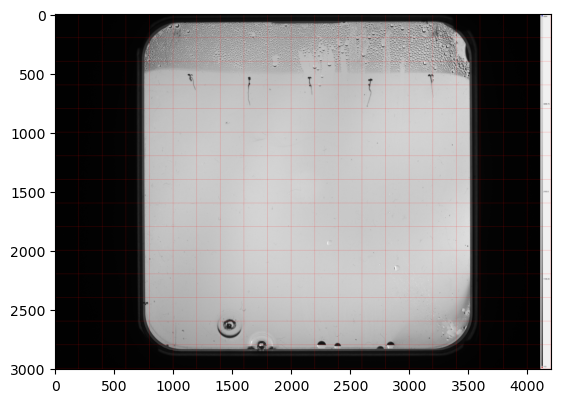

In [4]:
patch_size = 200

height, width = image.shape[:2]

for x in range(0, width, patch_size):
    cv2.line(image, (x, 0), (x, height), color=(255, 0, 0), thickness=1)

for y in range(0, height, patch_size):
    cv2.line(image, (0, y), (width, y), color=(255, 0, 0), thickness=1)

plt.imshow(image)

How to determine patch size? First of all, try to pick a number that divides the width (e.g. 1600) and height (e.g. 1200) perfectly. That is why 200 is a good choice. If we don't, there will be rectangles at the borders. For example let's try 128:

In [5]:
1600/128, 1200/128

(12.5, 9.375)

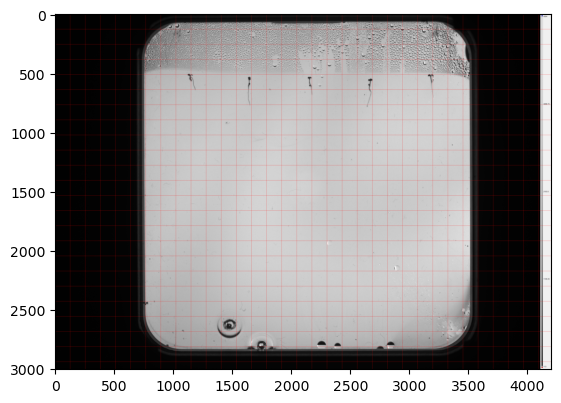

In [6]:
image = cv2.imread(image_path)

patch_size = 128

height, width = image.shape[:2]

for x in range(0, width, patch_size):
    cv2.line(image, (x, 0), (x, height), color=(255, 0, 0), thickness=1)

for y in range(0, height, patch_size):
    cv2.line(image, (0, y), (width, y), color=(255, 0, 0), thickness=1)

plt.imshow(image)

If you want to use a patch size that does not perfectly divide height or width you can consider the following:

- add padding
- resize the image
- crop the image

etc.

The other important consideration is the size of the object compared to the patch size. Imagine selecting a very small patch size:

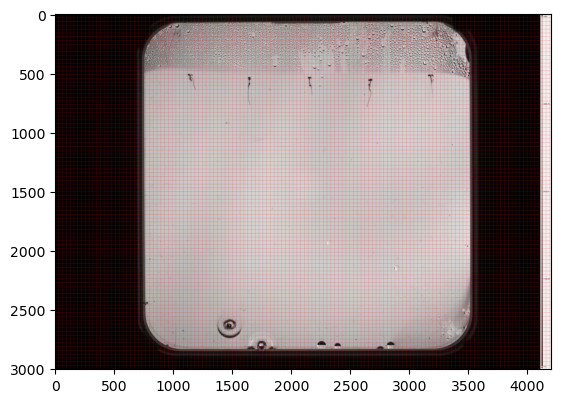

In [7]:
image = cv2.imread(image_path)

patch_size = 32

height, width = image.shape[:2]

for x in range(0, width, patch_size):
    cv2.line(image, (x, 0), (x, height), color=(255, 0, 0), thickness=1)

for y in range(0, height, patch_size):
    cv2.line(image, (0, y), (width, y), color=(255, 0, 0), thickness=1)

plt.imshow(image)

This is not a good patch size because the model is learning patch by patch, and a single patch might show only a part of the cell without any background or edge information.

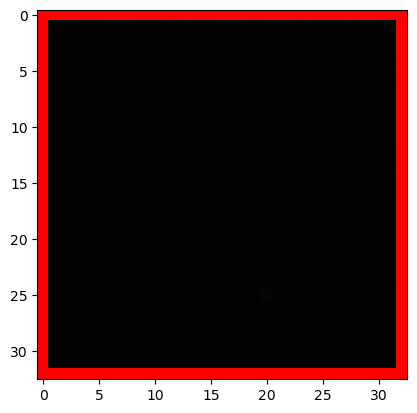

In [8]:
# What is this?
plt.imshow(image[1120:1153, 416:449])

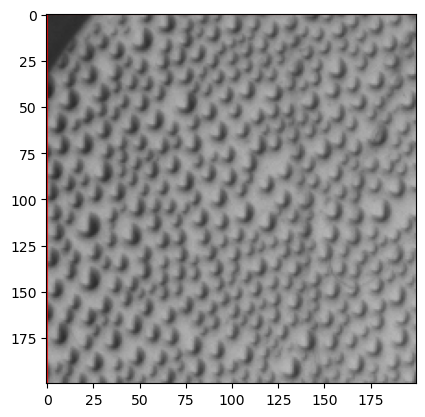

In [9]:
# It is much easier to decide what is what with a proper patch size
image = cv2.imread(image_path)

patch_size = 200

height, width = image.shape[:2]

for x in range(0, width, patch_size):
    cv2.line(image, (x, 0), (x, height), color=(255, 0, 0), thickness=1)

for y in range(0, height, patch_size):
    cv2.line(image, (0, y), (width, y), color=(255, 0, 0), thickness=1)

plt.imshow(image[200:400, 800:1000])

what if you still want to use a small patch size due to computational limitations? You can scale down the image:

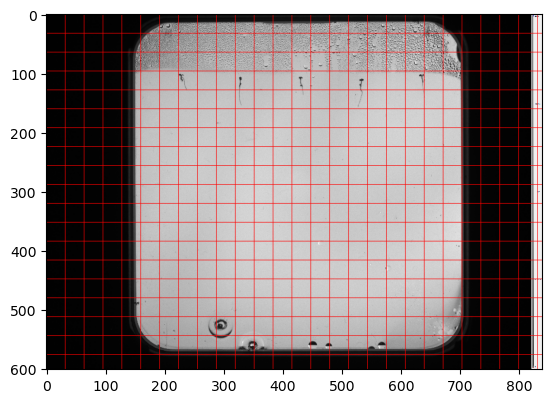

In [10]:
image = cv2.imread(image_path)

# scaling down the image to 20% of its original size
scaling_factor = 0.2
image = cv2.resize(image, (0,0), fx=scaling_factor, fy=scaling_factor)

# and using a patch size of 32
patch_size = 32

height, width = image.shape[:2]

for x in range(0, width, patch_size):
    cv2.line(image, (x, 0), (x, height), color=(255, 0, 0), thickness=1)

for y in range(0, height, patch_size):
    cv2.line(image, (0, y), (width, y), color=(255, 0, 0), thickness=1)

plt.imshow(image)

Another important factor is to use powers of 2 as patch size 32, 64, 128, 256 etc.

Using powers of two for image sizes in Convolutional Neural Networks (CNNs) greatly enhances computational efficiency and aligns well with the architecture of downsampling layers. Firstly, computational efficiency is significantly improved because modern hardware and deep learning frameworks are optimized for binary-aligned data, typical of power-of-two dimensions. This optimization leads to faster computations and more efficient memory usage, crucial for the intensive demands of training large neural networks. Secondly, the structure of CNNs often involves downsampling layers like max pooling or strided convolutions, which halve the dimensions of the image at each step. When the image size is a power of two, it can be evenly divided multiple times without fractional dimensions, simplifying the network design and avoiding complications with padding or other adjustments. This seamless compatibility with downsampling layers, combined with the computational benefits, makes the use of power-of-two image sizes a practical choice in CNNs.

In summary, to properly select a patch size you need to consider:
- the divisibility between the patch size and image size
- patch size vs object size
- computational requirements
- requirements on segmentation quality
- patch size of $(2^n, 2^n)$

etc.

What is the best patch size for this problem? I prefer 64, 128, or 256 but none of these sizes divide both height and width perfectly. So let's use 128 and pad the image accordingly.

In [11]:
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

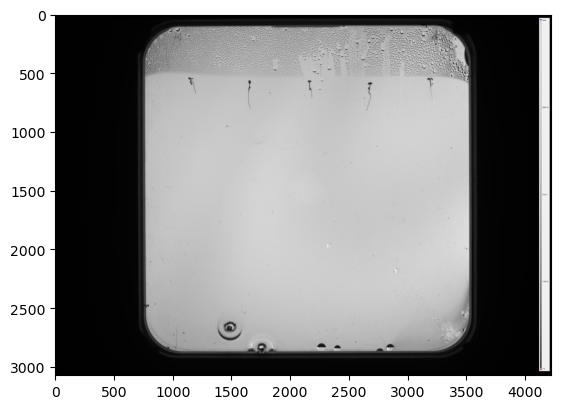

In [12]:
patch_size = 128
image = cv2.imread(image_path)
padded_image = padder(image, patch_size)
plt.imshow(padded_image)

In [13]:
# Sanity check
padded_image.shape[0] % patch_size, padded_image.shape[1] % patch_size

(0, 0)

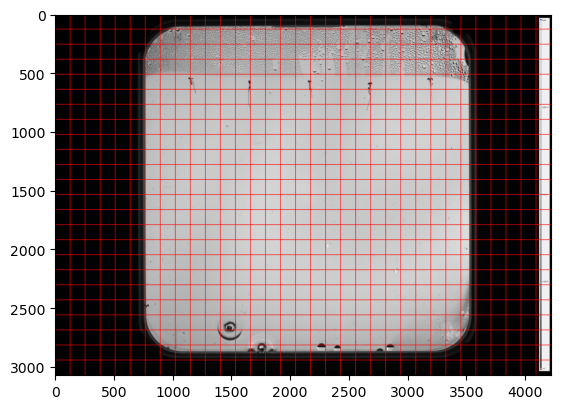

In [14]:
patch_size = 128

height, width = padded_image.shape[:2]

for x in range(0, width, patch_size):
    cv2.line(padded_image, (x, 0), (x, height), color=(255, 0, 0), thickness=3)

for y in range(0, height, patch_size):
    cv2.line(padded_image, (0, y), (width, y), color=(255, 0, 0), thickness=3)

plt.imshow(padded_image)

Now, how can we obtain the patches? As you can imagine, this is a common operation, so there is a Python library for that called [patchify](https://pypi.org/project/patchify/).

```pip install patchify```

In [15]:
from patchify import patchify, unpatchify

It can patch and stitch (unpatch) images easily

In [16]:
patch_size = 128
image = cv2.imread(image_path)
image = padder(image, patch_size)
patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)

In [17]:
patches.shape

(24, 33, 1, 128, 128, 3)

A single image contains 130 patchs of size (128, 128, 3). As you can see the shape contains the information for the location of the patch. The 3rd row 6th column patch can be accessed as:

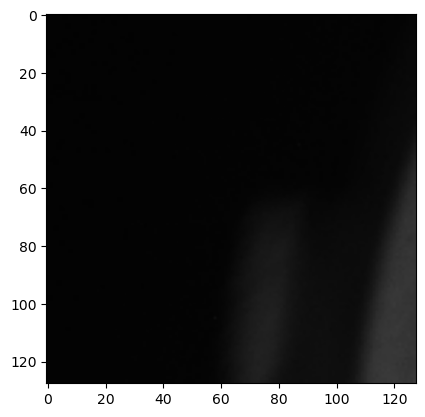

In [18]:
plt.imshow(patches[2, 5, 0])

stitching them back together is pretty easy, simply give the correct output size:

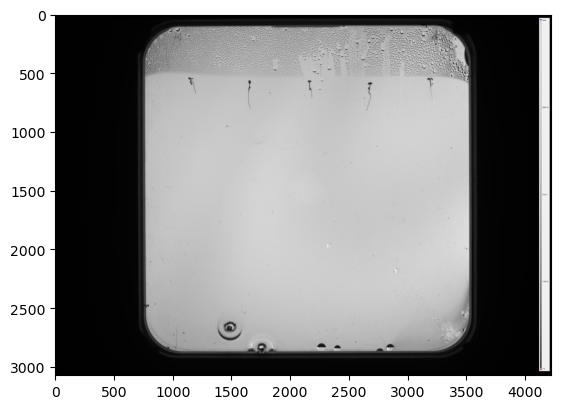

In [19]:
plt.imshow(unpatchify(patches, image.shape))

And you can change the step size to obtain overlapping patches.

In [20]:
patches = patchify(image, (patch_size, patch_size, 3), step=64)
patches.shape

(47, 65, 1, 128, 128, 3)

**Exercise 7.1**

Write a function called `dataset_generator` that reads images and their corresponding masks from a specified directory, scales them based on the provided scaling factor (if it is not 1), and then splits them into patches of the specified size. It returns two numpy arrays containing the patches of the images and their corresponding masks.

In [21]:
# import glob
# import os
# def dataset_generator(dataset_type, patch_size, scaling_factor):
#     """
#     Generates a dataset of image patches and corresponding mask patches for segmentation tasks.

#     This function reads images and their corresponding masks from a specified directory,
#     scales them based on the provided scaling factor, and then splits them into patches of
#     the specified size. It returns two numpy arrays containing the patches of the images and
#     their corresponding masks.

#     Args:
#     - dataset_type (str): The type of dataset to process ('train', 'test', etc.), used to 
#       determine the subdirectory within the blood cell dataset from which to load images.
#     - patch_size (int): The height and width of the square patches to be extracted from each 
#       image and mask. Assumes the images and masks are square.
#     - scaling_factor (float): A factor to scale the images and masks. If it's different from 1,
#       the images and masks are resized accordingly. A scaling factor greater than 1 enlarges 
#       the images/masks, while a factor less than 1 shrinks them.

#     Returns:
#     - X (numpy.ndarray): An array of image patches. Each patch is a numpy array of shape 
#       (patch_size, patch_size, 3), representing the height, width, and color channels.
#     - y (numpy.ndarray): An array of corresponding mask patches. Each mask patch is a numpy 
#       array of shape (patch_size, patch_size, 1), representing the height, width, and a single 
#       channel for the mask.

#     Note:
#     - The function expects a directory structure with separate subdirectories for images and 
#       masks within each dataset type (e.g., 'blood_cell_dataset/train_images/train/').
#     - It uses OpenCV for image processing and assumes the mask images are grayscale.
#     - The returned image and mask patches are normalized by dividing by 255.
#     """
#     X = []
#     y = []

#     # YOUR CODE HERE
#    # Directory paths for images and masks
#     images_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Notebooks\train_images'
#     masks_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Notebooks\train_masks'

#     # Find image and mask files using glob
#     image_files = sorted(glob.glob(os.path.join(images_dir, '*.png')))
#     mask_files = sorted(glob.glob(os.path.join(masks_dir, '*.png')))

#     for img_file, mask_file in zip(image_files, mask_files):
#         # Read image and mask
#         img = cv2.imread(img_file)
#         mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

#         # Resize image and mask based on scaling factor
#         if scaling_factor != 1:
#             img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)
#             mask = cv2.resize(mask, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)

#         # Split image and mask into patches
#         for i in range(0, img.shape[0], patch_size):
#             for j in range(0, img.shape[1], patch_size):
#                 img_patch = img[i:i + patch_size, j:j + patch_size]
#                 mask_patch = mask[i:i + patch_size, j:j + patch_size]

#                 # Ensure the patch sizes are consistent
#                 if img_patch.shape[:2] == (patch_size, patch_size) and mask_patch.shape[:2] == (patch_size, patch_size):
#                     X.append(img_patch)
#                     y.append(mask_patch[:, :, np.newaxis])  # Add a channel dimension for the mask


#     # Convert lists to NumPy arrays
#     X = np.array(X) / 255.0  # Normalize images
#     y = np.array(y) / 255.0  # Normalize masks
#     return X, y


In [22]:
import glob
def dataset_generator(dataset_type, patch_size, scaling_factor):
    """
    Generates a dataset of image patches and corresponding mask patches for segmentation tasks.

    This function reads images and their corresponding masks from a specified directory,
    scales them based on the provided scaling factor, and then splits them into patches of
    the specified size. It returns two numpy arrays containing the patches of the images and
    their corresponding masks.

    Args:
    - dataset_type (str): The type of dataset to process ('train', 'test', etc.), used to 
      determine the subdirectory within the blood cell dataset from which to load images.
    - patch_size (int): The height and width of the square patches to be extracted from each 
      image and mask. Assumes the images and masks are square.
    - scaling_factor (float): A factor to scale the images and masks. If it's different from 1,
      the images and masks are resized accordingly. A scaling factor greater than 1 enlarges 
      the images/masks, while a factor less than 1 shrinks them.

    Returns:
    - X (numpy.ndarray): An array of image patches. Each patch is a numpy array of shape 
      (patch_size, patch_size, 3), representing the height, width, and color channels.
    - y (numpy.ndarray): An array of corresponding mask patches. Each mask patch is a numpy 
      array of shape (patch_size, patch_size, 1), representing the height, width, and a single 
      channel for the mask.

    Note:
    - The function expects a directory structure with separate subdirectories for images and 
      masks within each dataset type (e.g., 'blood_cell_dataset/train_images/train/').
    - It uses OpenCV for image processing and assumes the mask images are grayscale.
    - The returned image and mask patches are normalized by dividing by 255.
    """
    X = []
    y = []

    # YOUR CODE HERE    

    for image_path in glob.glob(f'roots/{dataset_type}_images/{dataset_type}/*.png'):
        mask_path = image_path.replace('images',"masks").replace('.png', '_root_mask.tif')

        image = cv2.imread(image_path)
        image = padder(image, patch_size)
        if scaling_factor !=1:
            image = cv2.resize(image,(0,0), fx = scaling_factor, fy = scaling_factor)
        patches = patchify(image, ( patch_size,patch_size,3),step=patch_size)
        patches = patches.reshape(-1,patch_size,patch_size,3)
        X.append(patches)

        mask = cv2.imread(mask_path,0)
        mask = padder(mask, patch_size)
        if scaling_factor !=1:
            mask = cv2.resize(mask,(0,0), fx = scaling_factor, fy = scaling_factor)
        patches = patchify(mask, ( patch_size,patch_size),step=patch_size)
        patches = patches.reshape(-1,patch_size,patch_size,1)
        y.append(patches)
        

    X = np.array(X)
    y = np.array(y)
    X = X.reshape(-1,patch_size,patch_size,3)
    y = y.reshape(-1,patch_size,patch_size,1)
    X = X/255
    y = y/255
    
   
    return X, y


In [23]:
patch_size = 128
scaling_factor = 1

In [24]:
# X_train, y_train = dataset_generator(dataset_type='train',
#                                      patch_size=patch_size,
#                                      scaling_factor=scaling_factor)
# X_train.shape, y_train.shape # ((4680, 128, 128, 3), (4680, 128, 128, 1))

In [25]:
# X_val, y_val = dataset_generator(dataset_type='val',
#                                  patch_size=patch_size,
#                                  scaling_factor=scaling_factor)
# X_val.shape, y_val.shape # ((520, 128, 128, 3), (520, 128, 128, 1))

## 3 U-Net

We are ready to build the U-Net.

In [26]:
import tensorflow as tf
import keras.backend as K

In [27]:
# Let's implement two custom metrics f1 score and iou
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)

In [28]:
# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1, iou])
    model.summary()
    
    return model

In [29]:
model = simple_unet_model(patch_size, patch_size, 1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

**Exercise 7.2**

Train the model with `X_train`, `y_train`. Use `X_val` and `y_val` as validation data. Use early stopping.


In [30]:
# # YOUR CODE HERE
# # I got val_f1: 0.9402 - val_iou: 0.6931

from keras.callbacks import EarlyStopping

cb = EarlyStopping(monitor= "val_loss",
                   patience = 2,
                   restore_best_weights = "True",
                   mode="min")

# history = model.fit(X_train, y_train, batch_size=8, verbose=1, epochs=100, validation_data=(X_val, y_val), callbacks=(cb))

Let's take a look at example predictions:

In [31]:
# predicted_masks = model.predict(X_val)

In [32]:
# i = np.random.randint(0, predicted_masks.shape[0])
# print(i)
# predicted_mask = predicted_masks[i]
# #predicted_mask = predicted_mask.reshape(128, 128, 1)
# fig, ax = plt.subplots(1, 3)
# ax[0].imshow(X_val[i])
# ax[1].imshow(y_val[i])
# ax[2].imshow(predicted_mask)

Notice that we use sigmoid activations at the output layer. Therefore model will predict values between 0 and 1. To convert these predictions into a binary mask, we can use a threshold:

In [33]:
# i = np.random.randint(0, predicted_masks.shape[0])
# print(i)
# predicted_mask = predicted_masks[i]
# fig, ax = plt.subplots(1, 3)
# ax[0].imshow(X_val[i])
# ax[1].imshow(y_val[i])
# ax[2].imshow(predicted_mask>0.5) # threshold 0.5

## 4 Working with large data that doesn't fit your system memory.

There is one important issue we need to solve before completing this notebook. When we trained our U-Net, we have loaded all the dataset into memory. This is okay for a small dataset, but what if we have a dataset that does not fit the memory?

The U-net for image segmentation playlist contains the answer for that:

[222 - Working with large data that doesn't fit your system memory - Semantic Segmentation](https://www.youtube.com/watch?v=XhxF2JV6PcI)

So the idea is simply loading and unloading images batch by batch during training. But what about creating patches? We can create and save patches to a another directory, and flow the patches from directory. So let's do that first:

In [34]:
# Create a new directory for patches
# Folder name will be blood_cell_dataset_patched instead of blood_cell_dataset
import os
patch_dir = 'roots_patched'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)

In [35]:
def create_and_save_patches(dataset_type, patch_size, scaling_factor):
    """
    Splits images and their corresponding masks from a blood cell dataset into smaller patches and saves them.

    This function takes images and masks from a specified dataset type, scales them if needed, and then splits them into smaller patches. Each patch is saved as a separate file. This is useful for preparing data for tasks like image segmentation in machine learning.

    Parameters:
    - dataset_type (str): The type of the dataset to process (e.g., 'train', 'test'). It expects a directory structure like 'blood_cell_dataset/{dataset_type}_images/{dataset_type}' for images and 'blood_cell_dataset/{dataset_type}_masks/{dataset_type}' for masks.
    - patch_size (int): The size of the patches to be created. Patches will be squares of size patch_size x patch_size.
    - scaling_factor (float): The factor by which the images and masks should be scaled. A value of 1 means no scaling.

    Returns:
    None. The function saves the patches as .png files in directories based on their original paths, but replacing 'blood_cell_dataset' with 'blood_cell_dataset_patched'.

    Note:
    - The function assumes a specific directory structure and naming convention for the dataset.
    """
    for image_path in glob.glob(f'roots/{dataset_type}_images/{dataset_type}/*.png'):
        mask_path = image_path.replace('images', 'masks').replace('.png', '_root_mask.tif')

        image = cv2.imread(image_path)
        image = padder(image, patch_size)
        if scaling_factor != 1:
            image = cv2.resize(image, (0,0), fx=scaling_factor, fy=scaling_factor)
        patches = patchify(image, (patch_size, patch_size, 1), step=patch_size)
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        image_patch_path = image_path.replace('roots', patch_dir)
        for i, patch in enumerate(patches):
            image_patch_path_numbered = f'{image_patch_path[:-4]}_{i}.png'
            cv2.imwrite(image_patch_path_numbered, patch)

        mask_path = image_path.replace('image', 'mask').replace('.png', '_root_mask.tif')
        mask = cv2.imread(mask_path, 0)
        mask = padder(mask, patch_size)
        if scaling_factor != 1:
            mask = cv2.resize(mask, (0,0), fx=scaling_factor, fy=scaling_factor)
        patches = patchify(mask, (patch_size, patch_size), step=patch_size)
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        mask_patch_path = mask_path.replace('roots', patch_dir)
        for i, patch in enumerate(patches):
            mask_patch_path_numbered = f'{mask_patch_path[:-4]}_{i}.png'
            cv2.imwrite(mask_patch_path_numbered, patch)

In [36]:
create_and_save_patches('train', patch_size, scaling_factor)

In [37]:
create_and_save_patches('val', patch_size, scaling_factor)

Now we can flow the patches from the directory, as detailed in the video:

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [45]:
# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator(rescale=1./255)

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

Found 31680 images belonging to 1 classes.
Found 31680 images belonging to 1 classes.


In [46]:
# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Training masks
val_mask_datagen = ImageDataGenerator(rescale=1./255)

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

val_generator = zip(val_image_generator, val_mask_generator)

Found 7920 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.


In [47]:
model = simple_unet_model(patch_size, patch_size, 1)

cb = EarlyStopping(monitor='val_loss',
                   patience=2,
                   restore_best_weights='True',
                   mode='min')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 128, 128, 16  160         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_27 (Dropout)           (None, 128, 128, 16  0           ['conv2d_57[0][0]']              
                                )                                                           

In [48]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=10,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb]
)

Epoch 1/10


 122/1980 [>.............................] - ETA: 1:41 - loss: 0.0517 - accuracy: 0.9805 - f1: 0.0000e+00 - iou: 0.0132

KeyboardInterrupt: 

## 5 Inference

Now let's open an image, patch it, get predictions and stitch them back together:

In [ ]:
image_path = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\roots\train_images\train\002_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_01-Fish Eye Corrected.png'
image = cv2.imread(image_path)
image = padder(image, patch_size)

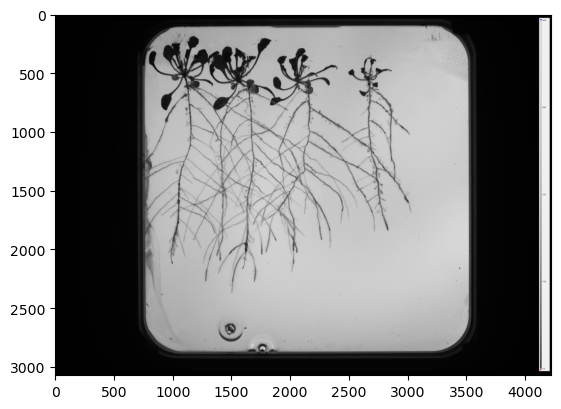

In [ ]:
plt.imshow(image)

In [ ]:
patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)

In [ ]:
i = patches.shape[0]
j = patches.shape[1]

In [ ]:
patches = patches.reshape(-1, patch_size, patch_size, 3)
patches.shape

(792, 128, 128, 3)

In [ ]:
preds = model.predict(patches/255)

25/25 [==============================] - 3s 65ms/step


In [ ]:
preds = preds.reshape(i, j, 128, 128)
preds.shape

(24, 33, 128, 128)

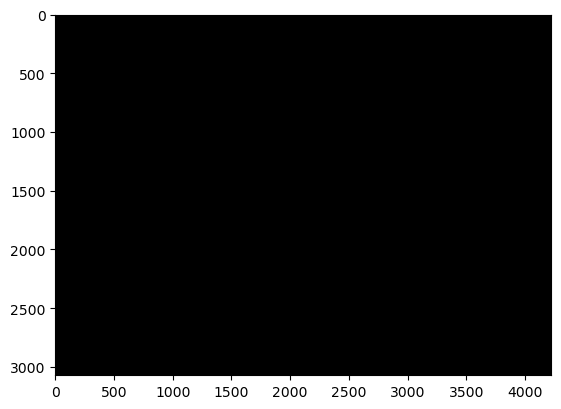

In [ ]:
predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))
plt.imshow(predicted_mask>0.5, cmap='gray')

## 6 Next steps

You can process the output image with opening and closing operations and then apply watershed for instance segmentation:

- [205 - U-Net plus watershed for instance segmentation](https://www.youtube.com/watch?v=lOZDTDOlqfk)

We have only covered binary classification, what if we have multiple classes?

- [208 - Multiclass semantic segmentation using U-Net](https://www.youtube.com/watch?v=XyX5HNuv-xE)

You might notice the patch borders when you stitch patches together. How can you deal with it?

- [229 - Smooth blending of patches for semantic segmentation of large images (using U-Net)](https://www.youtube.com/watch?v=HrGn4uFrMOM)

Transfer learning?

- [177 - Semantic segmentation made easy (using segmentation models library)](https://www.youtube.com/watch?v=J_XSd_u_Yew)